## 1. Graph Attention Networks

In [1]:
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Dataset

In [2]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="citeseer")

data = dataset[0]


C:\Users\user\anaconda3\envs\test\lib\site-packages\torch_geometric\typing.py:60: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\user\anaconda3\envs\test\Lib\site-packages\torch_scatter\_scatter_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\user\anaconda3\envs\test\lib\site-packages\torch_geometric\typing.py:98: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\user\anaconda3\envs\test\Lib\site-packages\torch_sparse\_convert_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Processing...
Done!


### Print information about the dataset

In [3]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: citeseer()
-------------------
Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6

Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False


In [4]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 48


### Plot dataset

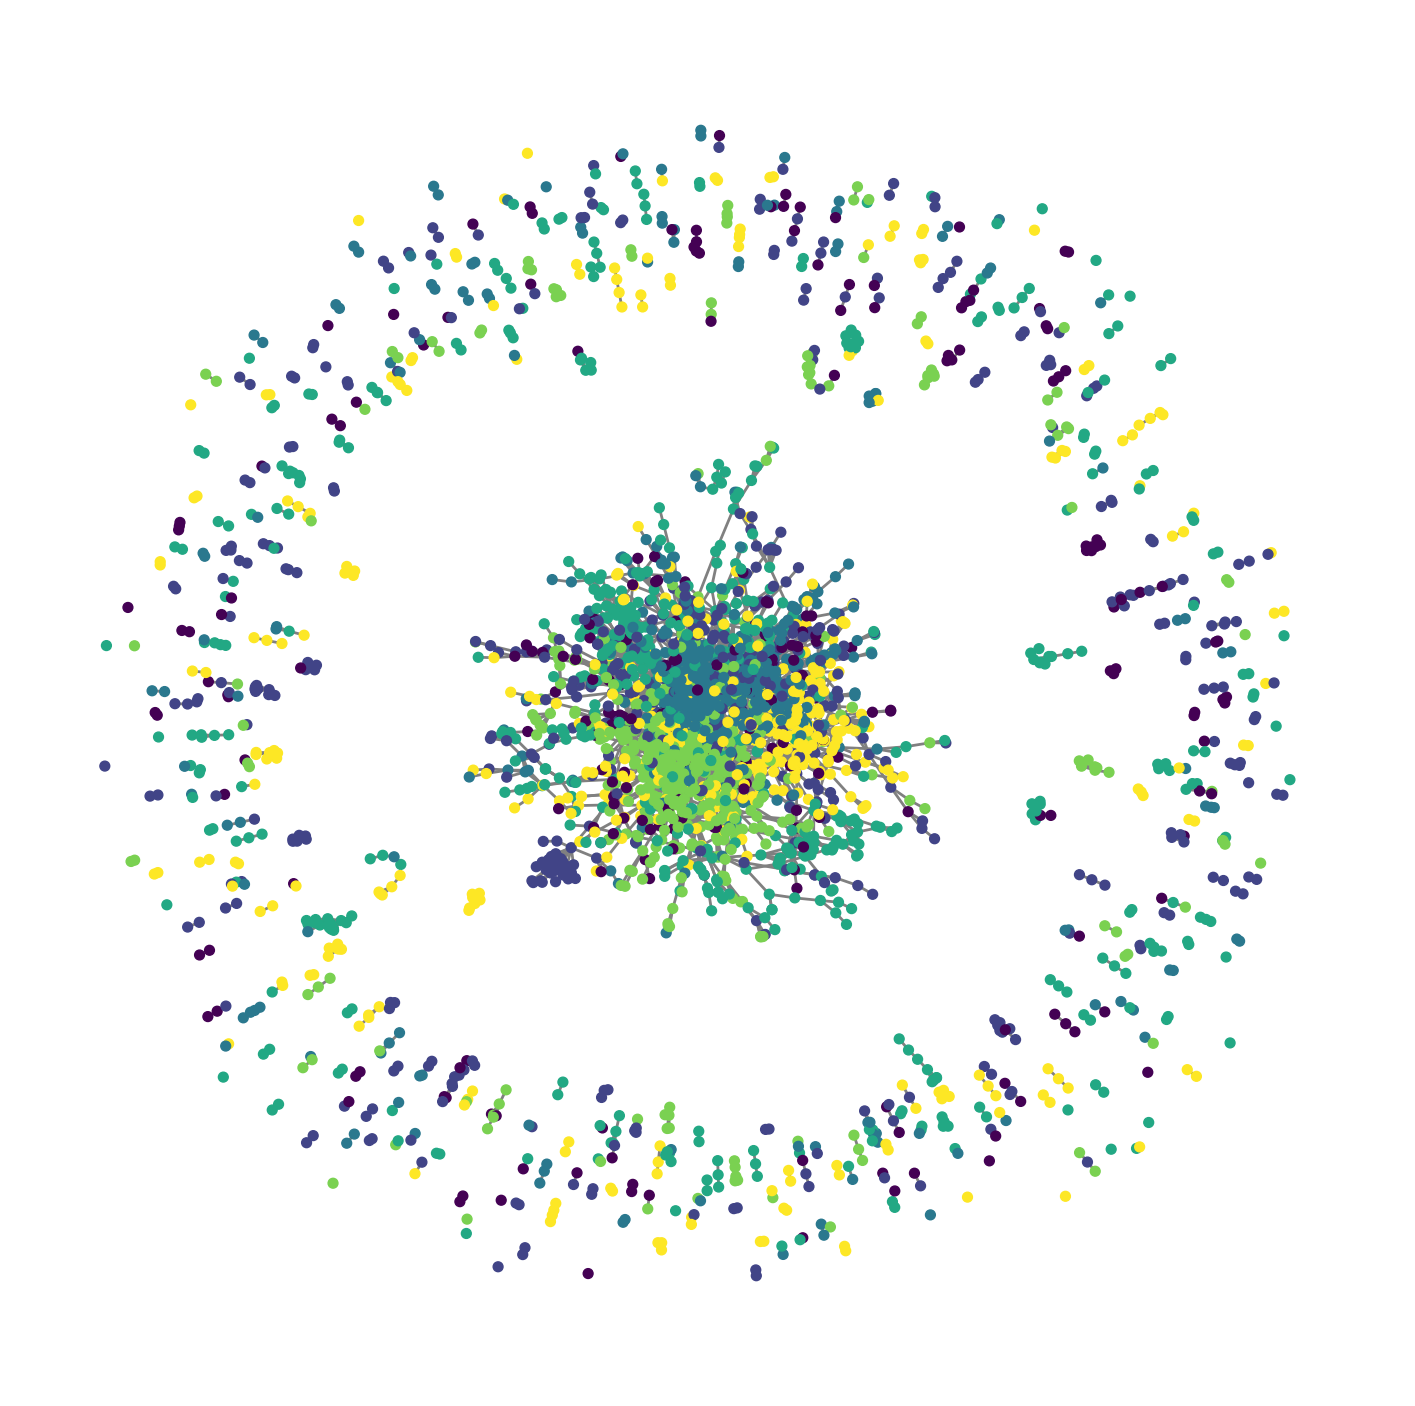

In [5]:
from torch_geometric.utils import to_networkx
# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

### Plot node degrees

<BarContainer object of 32 artists>

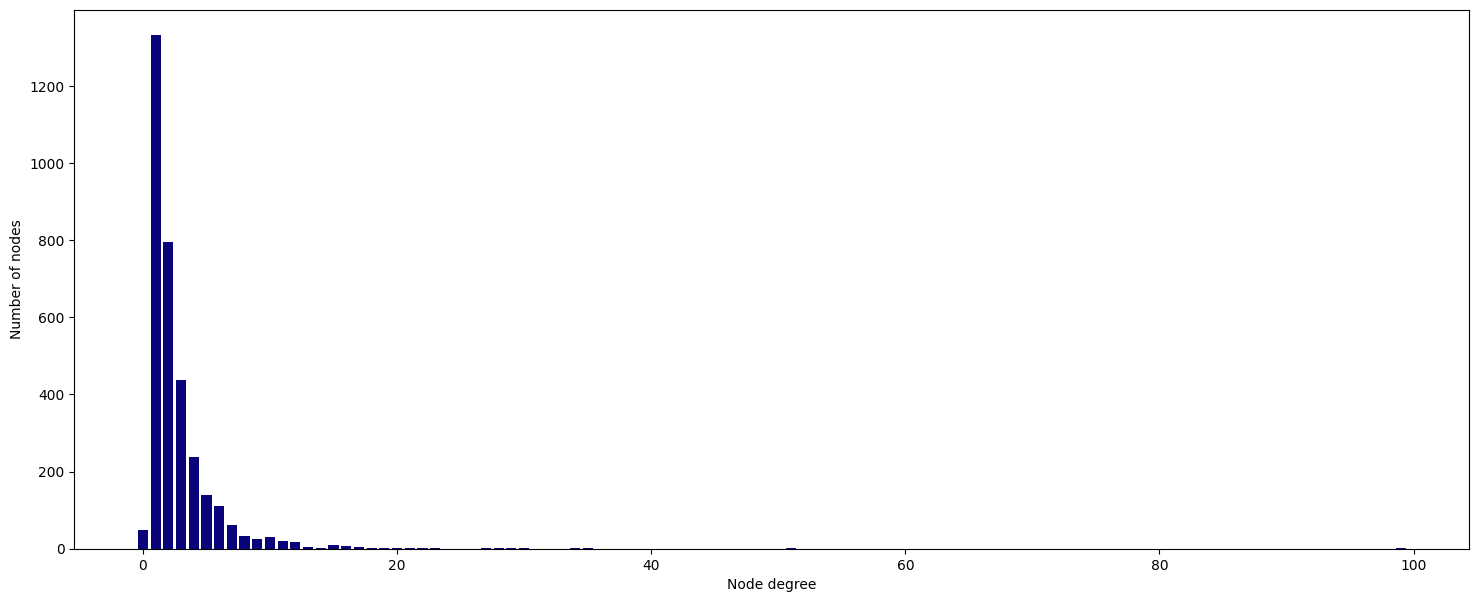

In [6]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

### Implement GAT vs. GCN

### 1. GCN model

In [7]:
import torch.nn.functional as F
import torch
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

### 2. GAT model

In [8]:
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

### Train function

In [9]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 5

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 1 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

In [10]:
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

#### Training GCN

In [17]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.797 | Train Acc:  12.50% | Val Loss: 1.80 | Val Acc: 15.80%
Epoch   1 | Train Loss: 1.679 | Train Acc:  58.33% | Val Loss: 1.75 | Val Acc: 34.00%
Epoch   2 | Train Loss: 1.510 | Train Acc:  74.17% | Val Loss: 1.68 | Val Acc: 47.80%
Epoch   3 | Train Loss: 1.379 | Train Acc:  80.83% | Val Loss: 1.62 | Val Acc: 45.20%
Epoch   4 | Train Loss: 1.181 | Train Acc:  80.83% | Val Loss: 1.56 | Val Acc: 45.60%
Epoch   5 | Train Loss: 1.042 | Train Acc:  84.17% | Val Loss: 1.51 | Val Acc: 46.00%

GCN test accuracy: 63.20%

CPU times: total: 13.7 s
Wall time: 2.01 s


#### Train GAT

In [18]:
%%time

# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
CPU times: total: 31.2 ms
Wall time: 5.01 ms


In [19]:


# Train
train(gat, data)

# Test
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.807 | Train Acc:  17.50% | Val Loss: 1.78 | Val Acc: 21.60%
Epoch   1 | Train Loss: 1.368 | Train Acc:  88.33% | Val Loss: 1.61 | Val Acc: 58.80%
Epoch   2 | Train Loss: 1.025 | Train Acc:  95.00% | Val Loss: 1.46 | Val Acc: 62.60%
Epoch   3 | Train Loss: 0.776 | Train Acc:  94.17% | Val Loss: 1.33 | Val Acc: 67.00%
Epoch   4 | Train Loss: 0.545 | Train Acc:  94.17% | Val Loss: 1.23 | Val Acc: 66.40%
Epoch   5 | Train Loss: 0.411 | Train Acc:  94.17% | Val Loss: 1.16 | Val Acc: 67.80%

GAT test accuracy: 69.50%



### t-SNE plots

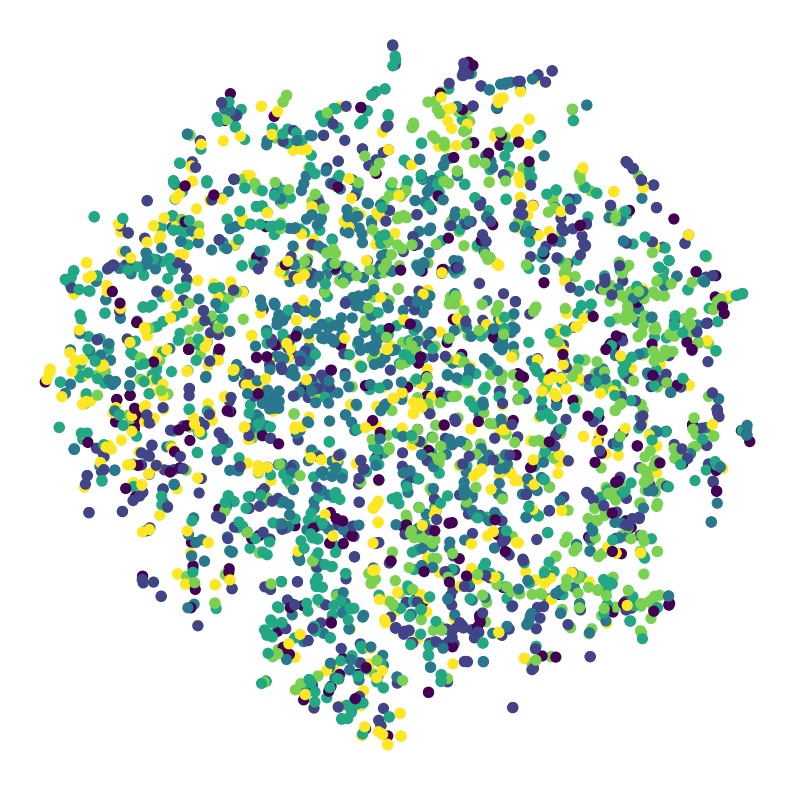

In [20]:
# Initialize new untrained model
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

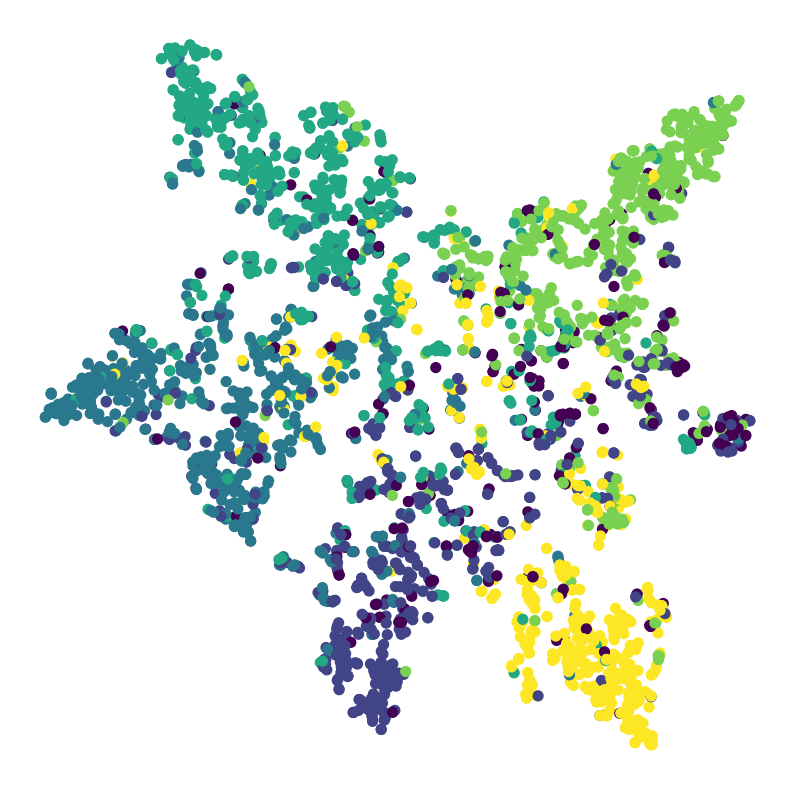

In [21]:
# Get embeddings
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

### 3. GATv2

In [24]:
class GATv2(torch.nn.Module):
    def __init__(self,num_features,dims, num_classes,  drop=0.0):
        super(GATv2, self).__init__()
        heads = 8
        self.h = None
        self.conv1 = GATv2Conv(num_features,dims, heads=heads, dropout = 0.3, concat=False)
        self.conv2 = GATv2Conv(dims, num_classes, heads=heads, concat=False, dropout=0.3)
        self.drop = torch.nn.Dropout(p=drop)
        self.optimizer = torch.optim.Adam(self.parameters(),lr=0.005,weight_decay=5e-4)
    def forward(self, x, edge_index,):
        x = F.elu(self.conv1(x, edge_index))
        x = self.drop(x)
        x = self.conv2(x, edge_index)
        return x, F.log_softmax(x, dim=1)

In [25]:
%%time

# Create GAT model
gat2 = GATv2(dataset.num_features, 8, dataset.num_classes)
print(gat2)

GATv2(
  (conv1): GATv2Conv(3703, 8, heads=8)
  (conv2): GATv2Conv(8, 6, heads=8)
  (drop): Dropout(p=0.0, inplace=False)
)
CPU times: total: 0 ns
Wall time: 5 ms


In [26]:
# Train
train(gat2, data)

# Test
acc = test(gat2, data)
print(f'\nGAT2 test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.793 | Train Acc:  17.50% | Val Loss: 1.79 | Val Acc: 15.40%
Epoch   1 | Train Loss: 1.774 | Train Acc:  25.83% | Val Loss: 1.78 | Val Acc: 25.00%
Epoch   2 | Train Loss: 1.755 | Train Acc:  42.50% | Val Loss: 1.77 | Val Acc: 32.20%
Epoch   3 | Train Loss: 1.723 | Train Acc:  61.67% | Val Loss: 1.76 | Val Acc: 36.40%
Epoch   4 | Train Loss: 1.693 | Train Acc:  77.50% | Val Loss: 1.75 | Val Acc: 45.80%
Epoch   5 | Train Loss: 1.669 | Train Acc:  81.67% | Val Loss: 1.74 | Val Acc: 50.60%

GAT test accuracy: 55.90%



### 4. RGAT (Relational GAT on heterogeneous graph)

In [45]:
!pip install rdflib
import os.path as osp
import time

import torch
import torch.nn.functional as F

from torch_geometric.datasets import Entities
from torch_geometric.nn import RGATConv

#path = osp.join(".", '..', 'data', 'Entities')'AIFB'
dataset = Entities(".", 'MUTAG')
data = dataset[0]
data.x = torch.randn(data.num_nodes, 16)


Extracting .\mutag.tgz
Processing...
Done!


#### RGAT Class

In [46]:

class RGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 num_relations):
        super().__init__()
        self.conv1 = RGATConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGATConv(hidden_channels, hidden_channels, num_relations)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type).relu()
        x = self.conv2(x, edge_index, edge_type).relu()
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

In [47]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = RGAT(16, 16, dataset.num_classes, dataset.num_relations).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)



In [48]:

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_type)
    loss = F.nll_loss(out[data.train_idx], data.train_y)
    loss.backward()
    optimizer.step()
    return float(loss)



In [49]:

@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_type).argmax(dim=-1)
    train_acc = float((pred[data.train_idx] == data.train_y).float().mean())
    test_acc = float((pred[data.test_idx] == data.test_y).float().mean())
    return train_acc, test_acc



In [50]:

times = []
for epoch in range(1, 51):
    start = time.time()
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f} '
          f'Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 01, Loss: 0.7228, Train: 0.6287 Test: 0.5294
Epoch: 02, Loss: 0.6881, Train: 0.6103 Test: 0.6618
Epoch: 03, Loss: 0.6595, Train: 0.6103 Test: 0.6618
Epoch: 04, Loss: 0.6447, Train: 0.6103 Test: 0.6618
Epoch: 05, Loss: 0.6368, Train: 0.6103 Test: 0.6618
Epoch: 06, Loss: 0.6225, Train: 0.6103 Test: 0.6618
Epoch: 07, Loss: 0.6118, Train: 0.6140 Test: 0.6618
Epoch: 08, Loss: 0.5962, Train: 0.6434 Test: 0.6618
Epoch: 09, Loss: 0.5762, Train: 0.6618 Test: 0.6618
Epoch: 10, Loss: 0.5610, Train: 0.6985 Test: 0.6765
Epoch: 11, Loss: 0.5417, Train: 0.7500 Test: 0.6471
Epoch: 12, Loss: 0.5265, Train: 0.7904 Test: 0.6912
Epoch: 13, Loss: 0.5095, Train: 0.7941 Test: 0.6471
Epoch: 14, Loss: 0.4863, Train: 0.8051 Test: 0.6324
Epoch: 15, Loss: 0.4664, Train: 0.8493 Test: 0.6618
Epoch: 16, Loss: 0.4426, Train: 0.8603 Test: 0.6618
Epoch: 17, Loss: 0.4212, Train: 0.8750 Test: 0.6765
Epoch: 18, Loss: 0.3996, Train: 0.8787 Test: 0.6765
Epoch: 19, Loss: 0.3810, Train: 0.8897 Test: 0.6765
Epoch: 20, L